In [0]:
import pandas as pd
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt

np.random.seed(0)

dtype_float = torch.FloatTensor
dtype_long = torch.LongTensor



Read in the data:

In [2]:
dat = pd.read_csv("https://raw.githubusercontent.com/salesforce/TransmogrifAI/master/helloworld/src/main/resources/IrisDataset/bezdekIris.data", header = None)
dat


,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


Compute the train/test/validation split, and transform the y's into integers.

In [0]:
from sklearn.preprocessing import LabelEncoder



all_x = dat.loc[:, 0:3].to_numpy()
all_y_raw = dat.loc[:, 4].to_numpy()



le = LabelEncoder()
le.fit(all_y_raw)
all_y = le.transform(all_y_raw)

idx = np.random.permutation(range(all_x.shape[0]))
train_idx = idx[:60]
test_idx = idx[60:100]
valid_idx = idx[100:]

train_x = all_x[train_idx]
train_y = all_y[train_idx]

test_x = all_x[test_idx]
test_y = all_y[test_idx]

valid_x = all_x[valid_idx]
valid_y = all_y[valid_idx]

Read the train/validation/test sets into torch variables

In [0]:
x = Variable(torch.from_numpy(train_x), requires_grad=False).type(dtype_float)
y_classes = Variable(torch.from_numpy(train_y), requires_grad=False).type(dtype_long)

x_valid = Variable(torch.from_numpy(valid_x), requires_grad=False).type(dtype_float)
y_validclasses = Variable(torch.from_numpy(valid_y), requires_grad=False).type(dtype_long)


x_test = Variable(torch.from_numpy(test_x), requires_grad=False).type(dtype_float)
y_testclasses = Variable(torch.from_numpy(test_y), requires_grad=False).type(dtype_long)

Define a network that corrsponds to multinomial logistic regression:

In [0]:
dim_x = 4 # number of features: in this case 4 attributes
dim_out = 3 # number of classes we're predicting. We have 3 types of flowers

model_logreg = torch.nn.Sequential(
                torch.nn.Linear(dim_x, dim_out)
)

Train the logistic regression:

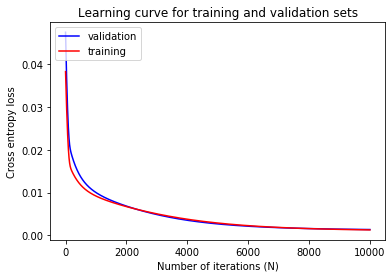

In [6]:
loss_train = [] # loss for the training set
loss_valid = [] # loss for the validation set

learning_rate = 1e-3
N = 10000 # number of gradient descent iterations
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_logreg.parameters(), lr=learning_rate)

for t in range(N):
    y_pred = model_logreg(x)
    loss = loss_fn(y_pred, y_classes)
    loss_train.append(loss.data.numpy().reshape((1,))[0]/len(y_classes))

    y_validpred = model_logreg(x_valid)
    loss_v = loss_fn(y_validpred, y_validclasses)
    loss_valid.append(loss_v.data.numpy().reshape((1,))[0]/len(y_validclasses))

    model_logreg.zero_grad()  # Zero out the previous gradient computation
    loss.backward()    # Compute the gradient
    optimizer.step()   # Use the gradient information to
                       # make a step


# Problem 3: Plotting learning curve

plt.plot(range(N), loss_valid, color='b', label='validation')
plt.plot(range(N), loss_train, color='r', label='training')
plt.legend(loc='upper left')
plt.title("Learning curve for training and validation sets")
plt.xlabel("Number of iterations (N)")
plt.ylabel("Cross entropy loss")
plt.show()

There are several things to note here:

1. When computing the cost to display, we divided the cost for the entire training/validation set by the number of training cases. That makes the training and validation costs displayed commesurate (since the training set is of size 60 and the validation set is of size 50, we'd expect the training cost to be larger just because it's the sum of the costs for all the datapoints).

2. It's quite difficult to make out any difference between the training and the validation sets here. If we re-run the same code (but starting from the weights obtained at iteration 10000, since we won't redefine `model_logreg`, we'll see some difference (even though it is tiny)

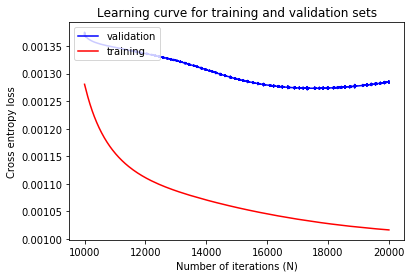

In [7]:
loss_train = [] # loss for the training set
loss_valid = [] # loss for the validation set

learning_rate = 1e-3
N = 10000 # number of gradient descent iterations
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_logreg.parameters(), lr=learning_rate)

for t in range(N):
    y_pred = model_logreg(x)
    loss = loss_fn(y_pred, y_classes)
    loss_train.append(loss.data.numpy().reshape((1,))[0]/len(y_classes))

    y_validpred = model_logreg(x_valid)
    loss_v = loss_fn(y_validpred, y_validclasses)
    loss_valid.append(loss_v.data.numpy().reshape((1,))[0]/len(y_validclasses))

    model_logreg.zero_grad()  # Zero out the previous gradient computation
    loss.backward()    # Compute the gradient
    optimizer.step()   # Use the gradient information to
                       # make a step


# Problem 3: Plotting learning curve

plt.plot(range(N, 2*N), loss_valid, color='b', label='validation')
plt.plot(range(N, 2*N), loss_train, color='r', label='training')
plt.legend(loc='upper left')
plt.title("Learning curve for training and validation sets")
plt.xlabel("Number of iterations (N)")
plt.ylabel("Cross entropy loss")
plt.show()

In [8]:
loss_train[-1]

0.0010166171938180923

Let's now define a one-hidden layer neural network with 3 hidden units:

In [0]:
dim_x = 4 # number of features: in this case 4 attributes
dim_h = 3 # number of hidden units
dim_out = 3 # number of classes we're predicting. We have 3 types of flowers

model_ann = torch.nn.Sequential(
    torch.nn.Linear(dim_x, dim_h),
    torch.nn.ReLU(),
    torch.nn.Linear(dim_h, dim_out),
)

loss_fn = torch.nn.CrossEntropyLoss()

loss_train = [] # loss for the training set
loss_valid = [] # loss for the validation set

learning_rate = 1e-3
N = 10000 # number of gradient descent iterations

optimizer = torch.optim.Adam(model_ann.parameters(), lr=learning_rate)

for t in range(N):
    y_pred = model_ann(x)
    loss = loss_fn(y_pred, y_classes)
    loss_train.append(loss.data.numpy().reshape((1,))[0]/len(y_classes))

    y_validpred = model_ann(x_valid)
    loss_v = loss_fn(y_validpred, y_validclasses)
    loss_valid.append(loss_v.data.numpy().reshape((1,))[0]/len(y_validclasses))

    model_ann.zero_grad()  # Zero out the previous gradient computation
    loss.backward()    # Compute the gradient
    optimizer.step()   # Use the gradient information to
                       # make a step

Let's now plot the learning curves for the ANN:

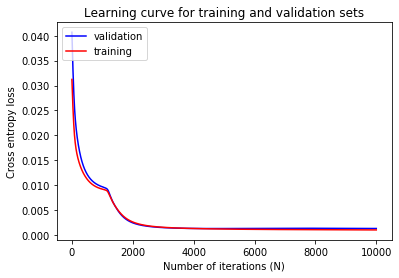

In [10]:
plt.plot(range(N), loss_valid, color='b', label='validation')
plt.plot(range(N), loss_train, color='r', label='training')
plt.legend(loc='upper left')
plt.title("Learning curve for training and validation sets")
plt.xlabel("Number of iterations (N)")
plt.ylabel("Cross entropy loss")
plt.show()

Because the neural network is more flexible, we expect to see smaller costs for the training set. Let's display the next 10,000 iterations as before:

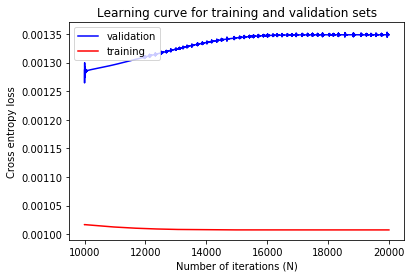

In [11]:
loss_train = [] # loss for the training set
loss_valid = [] # loss for the validation set

learning_rate = 1e-3
N = 10000 # number of gradient descent iterations
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_logreg.parameters(), lr=learning_rate)

for t in range(N):
    y_pred = model_logreg(x)
    loss = loss_fn(y_pred, y_classes)
    loss_train.append(loss.data.numpy().reshape((1,))[0]/len(y_classes))

    y_validpred = model_logreg(x_valid)
    loss_v = loss_fn(y_validpred, y_validclasses)
    loss_valid.append(loss_v.data.numpy().reshape((1,))[0]/len(y_validclasses))

    model_logreg.zero_grad()  # Zero out the previous gradient computation
    loss.backward()    # Compute the gradient
    optimizer.step()   # Use the gradient information to
                       # make a step


# Problem 3: Plotting learning curve

plt.plot(range(N, 2*N), loss_valid, color='b', label='validation')
plt.plot(range(N, 2*N), loss_train, color='r', label='training')
plt.legend(loc='upper left')
plt.title("Learning curve for training and validation sets")
plt.xlabel("Number of iterations (N)")
plt.ylabel("Cross entropy loss")
plt.show()

In [12]:
loss_train[-1]

0.0010073543215791383

The loss is a tiny bit smaller per training example. The validation cost is also similar.

In [13]:
dim_x = 4 # number of features: in this case 4 attributes
dim_h = 3 # number of hidden units
dim_out = 3 # number of classes we're predicting. We have 3 types of flowers


model = torch.nn.Sequential(
    torch.nn.Linear(dim_x, dim_h),
    torch.nn.ReLU(),
    torch.nn.Linear(dim_h, dim_out),
)


# Problem 4: get the performance on the testing set
# idea is to train network with different dim_h and pick the one with the highest valudation set accuracy as your model of choice
y_trainpred = model(x).data.numpy()
y_validpred = model(x_valid).data.numpy()
y_testpred = model(x_test).data.numpy()
print('accuracy on training set: ', np.mean(np.argmax(y_trainpred, 1) == train_y))
print('accuracy on validation set: ', np.mean(np.argmax(y_validpred, 1) == valid_y))
print('accuracy on testing set: ', np.mean(np.argmax(y_testpred, 1) == test_y))


# Problem 5: regularization
# Idea is to just rerun the gradient descent, but add the penalty term to loss function
lam=0.01
learning_rate = 1e-3
N = 10000 # number of gradient descent iterations

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for t in range(N):
    y_pred = model(x)
    loss = loss_fn(y_pred, y_classes) + lam * ( torch.pow(torch.pow(torch.norm(model[0].weight), 2) + torch.pow(torch.norm(model[2].weight), 2), 0.5))
    loss_train.append(loss.data.numpy().reshape((1,))[0])

    y_validpred = model(x_valid)
    loss_v = loss_fn(y_validpred, y_validclasses)
    loss_valid.append(loss_v.data.numpy().reshape((1,))[0])

    model.zero_grad()  # Zero out the previous gradient computation
    loss.backward()    # Compute the gradient
    optimizer.step()   # Use the gradient information to
                       # make a step

y_trainpred = model(x).data.numpy()
y_validpred = model(x_valid).data.numpy()
y_testpred = model(x_test).data.numpy()
print('accuracy on training set: ', np.mean(np.argmax(y_trainpred, 1) == train_y))
print('accuracy on validation set: ', np.mean(np.argmax(y_validpred, 1) == valid_y))
print('accuracy on testing set: ', np.mean(np.argmax(y_testpred, 1) == test_y))


# Problem 6: predicting probabilities for a new instance
#SepalLength = 5.8
#SepalWidth = 5.8
#PetalLength = 5.8
#PetalWidth = 5.8

x_new = np.array([5.8,5.8,5.8,5.8])
x_newtorch = Variable(torch.from_numpy(x_new), requires_grad=False).type(dtype_float)

predictedy = model(x_newtorch).data.numpy() # these are the raw output values for each of the 3 classes

# Apply softmax to obtain class probabilities: exp(o_i) / (sum_i  exp(o_i) )
#Setosa, Versicolor, and Viriginica correspond to 0, 1, and 2 respectively
probs = np.exp(predictedy) / np.sum(np.exp(predictedy))
print('predicted class label: ', np.argmax(probs))


#Problem 7: with three hidden units, take the first hidden unit, and display the weights that connect the inputs to it.

# weights from input to hidden layer:
model[0].weight # row i of the 2d array represents weights to the i_th hidden unit
weights_u1 = model[0].weight[0,:]
print(weights_u1)

accuracy on training set:  0.26666666666666666
accuracy on validation set:  0.38
accuracy on testing set:  0.375
accuracy on training set:  0.9833333333333333
accuracy on validation set:  0.94
accuracy on testing set:  0.975
predicted class label:  2
tensor([-6.0148e-41,  1.8359e-40, -1.5789e-40,  1.2537e-40],
       grad_fn=<SliceBackward>)
